In [56]:
# -----------------------------------------------------------------------------
# Autor: Pedro J. Lancheros / Peter Boat
# Fecha: 2026-01-30 | Hora: 15:35 (-5 UTC)
# Versión: v26.1 (Arquitectura Sentinel)
# Bloque: #0 - Infraestructura, Rutas y Blindaje de Activos
# -----------------------------------------------------------------------------

from google.colab import drive
import os
from datetime import datetime

# 1. Montaje Blindado de Drive (force_remount para evitar sesiones fantasma)
if not os.path.exists('/content/drive'):
    print("📡 Conectando con la infraestructura de Google Drive...")
    drive.mount('/content/drive', force_remount=True)

# 2. Definición de Rutas Maestras
BASE_PATH = "/content/drive/MyDrive/01_projects/crsn-slides-actividades-2025"
EXCEL_PATH = os.path.join(BASE_PATH, "vf.ESTADISTICAS_SABANA_NORTE_2015-2025.xlsx")
LOGO_PATH = os.path.join(BASE_PATH, "crsn-logo-dark-circulo.png")

# 3. Nomenclatura Incremental PJLA (Staging Area)
TS = datetime.now().strftime("%Y%m%d_%H%M")
# Usamos un nombre más descriptivo para la carpeta de producción
OUTPUT_FOLDER = os.path.join(BASE_PATH, f"PRODUCCION_PJLA_{TS}")

if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# 4. Auditoría de Activos Críticos (Pre-flight Check)
status_excel = "READY" if os.path.exists(EXCEL_PATH) else "MISSING ❌"
status_logo = "READY" if os.path.exists(LOGO_PATH) else "OPTIONAL ⚠️"

# --- CIERRE DEL BLOQUE ---
print("=" * 50)
print(f"🚀 SISTEMA INICIALIZADO - ID: {TS}")
print(f"📂 DIRECTORIO DE SALIDA: {os.path.basename(OUTPUT_FOLDER)}")
print(f"📊 EXCEL MAESTRO: {status_excel}")
print(f"🖼️ LOGO CORPORATIVO: {status_logo}")
print("=" * 50)

🚀 SISTEMA INICIALIZADO - ID: 20260130_2136
📂 DIRECTORIO DE SALIDA: PRODUCCION_PJLA_20260130_2136
📊 EXCEL MAESTRO: READY
🖼️ LOGO CORPORATIVO: READY


In [61]:
# -----------------------------------------------------------------------------
# Autor: Pedro J. Lancheros / Peter Boat
# Fecha: 2026-01-30 | Hora: 16:55 (-5 UTC)
# Versión: v26.3 (Audit de Archivos)
# Bloque: #0.2 - Verificación de Salidas de Producción
# -----------------------------------------------------------------------------

import os

print(f"🧐 Auditando carpeta de producción: {os.path.basename(OUTPUT_FOLDER)}")
print("-" * 50)
files = os.listdir(OUTPUT_FOLDER)
for i, f in enumerate(files, 1):
    size = os.path.getsize(os.path.join(OUTPUT_FOLDER, f)) / 1024
    print(f"{i}. [FILE] {f:<35} | {size:>7.2f} KB")
print("-" * 50)
print(f"✅ Total de activos creados: {len(files)}")

🧐 Auditando carpeta de producción: PRODUCCION_PJLA_20260130_2136
--------------------------------------------------
1. [FILE] stg_diezmos.csv                     |    2.07 KB
2. [FILE] stg_siervos.csv                     |    1.17 KB
3. [FILE] heatmap_siervos.png                 |  389.24 KB
4. [FILE] CRSN_PRESENTACION_MAESTRA_V1.pptx   |  367.32 KB
5. [FILE] diezmos_crecimiento.png             |  240.37 KB
6. [FILE] CRSN_PRESENTACION_FINAL_PJLA.pptx   |  568.74 KB
--------------------------------------------------
✅ Total de activos creados: 6


In [57]:
# ==============================================================================
# BLOQUE 1: ETL & AUDITORÍA DE DATOS (STAGING AREA)
# PROYECTO: CRSN MASTER 2015-2025 | Versión: vPJLA_v5.7_AUDIT
# ==============================================================================

import pandas as pd
import numpy as np
import os

def ejecutar_bloque_1_hardcore(excel_path, output_folder):
    years = range(2015, 2026)
    stats = {"success": [], "warnings": [], "errors": []}
    diezmos_list = []
    siervos_list = []

    # Lista Maestra de Ministerios (Estándar 18)
    mins_targets = [
        "UJIERES", "ALABANZA", "VISA", "NICODEMO", "ROCA KIDS", "ORACION",
        "MUJERES", "HOMBRES", "CASADOS", "TMT", "J25", "AÑOS DORADOS",
        "EJECUTIVOS", "COMUNICACIONES", "ROCAFE", "CLUBES", "JOSUES", "CLUB DE AMIGOS"
    ]

    print(f"🕵️  AUDITORÍA INICIADA: Procesando matriz 2015-2025...")
    print("-" * 50)

    for year in years:
        try:
            # Carga de hoja
            df = pd.read_excel(excel_path, sheet_name=str(year), header=None)

            # --- ETL DIEZMOS ---
            d_idx = df[df.apply(lambda r: r.astype(str).str.fullmatch('DIEZMOS', case=False).any(), axis=1)].index
            f_diezmos = False
            if not d_idx.empty:
                vals = pd.to_numeric(df.iloc[d_idx[0], 1:13], errors='coerce').fillna(0).tolist()
                diezmos_list.append([year] + vals + [sum(vals)])
                f_diezmos = True
            else:
                diezmos_list.append([year] + [0]*13)

            # --- ETL SIERVOS ---
            s_header = df[df.apply(lambda r: r.astype(str).str.contains('SIERVOS', case=False).any(), axis=1)].index
            y_data = {"AÑO": year}
            f_siervos = False

            if not s_header.empty:
                start = s_header[0] + 1
                for m_name in mins_targets:
                    m_row = df.iloc[start:start+30, 0].astype(str).str.contains(m_name.replace('+', '\\+'), case=False, na=False)
                    if m_row.any():
                        r_idx = m_row[m_row].index[0]
                        m_vals = pd.to_numeric(df.iloc[r_idx, 1:13], errors='coerce').fillna(0)
                        y_data[m_name] = m_vals.max() # Tomamos el pico para resiliencia
                        f_siervos = True
                    else:
                        y_data[m_name] = 0
            siervos_list.append(y_data)

            # Registro de progreso
            if f_diezmos and f_siervos:
                stats["success"].append(year)
                print(f"   ✅ {year}: Datos completos.")
            else:
                stats["warnings"].append(year)
                print(f"   ⚠️  {year}: Datos parciales encontrados.")

        except Exception as e:
            stats["errors"].append(f"{year}: {str(e)}")
            print(f"   ❌ {year}: ERROR CRÍTICO -> {e}")

    # --- PERSISTENCIA (Generación de CSVs) ---
    df_d = pd.DataFrame(diezmos_list, columns=['AÑO'] + [f'MES_{i}' for i in range(1,13)] + ['TOTAL'])
    # Calcular Índice 100
    base_2015 = df_d.loc[df_d['AÑO']==2015, 'TOTAL'].values[0]
    df_d['INDICE'] = (df_d['TOTAL'] / (base_2015 if base_2015 > 0 else 1)) * 100

    df_s = pd.DataFrame(siervos_list)

    # Guardar en la carpeta incremental
    path_d = os.path.join(output_folder, "stg_diezmos.csv")
    path_s = os.path.join(output_folder, "stg_siervos.csv")
    df_d.to_csv(path_d, index=False)
    df_s.to_csv(path_s, index=False)

    # ==========================================================================
    # PRINTOUT DE RESULTADOS FINALES
    # ==========================================================================
    print("\n" + "═"*50)
    print("📊 REPORTE FINAL DE INGENIERÍA - BLOQUE #1")
    print("═"*50)
    print(f"✅ ÉXITO TOTAL:  {len(stats['success'])} años")
    print(f"⚠️  ADVERTENCIAS: {len(stats['warnings'])} años")
    print(f"❌ ERRORES:      {len(stats['errors'])} años")
    print("-" * 50)

    if len(stats['errors']) == 0:
        print("🚀 ESTADO GLOBAL: SUCCESSFUL - CAPA DE STAGING LISTA")
    else:
        print("🚨 ESTADO GLOBAL: FAILED - REVISAR LOGS DE ERROR")

    print(f"📂 ARCHIVOS: {os.path.basename(path_d)} | {os.path.basename(path_s)}")
    print("═"*50 + "\n")

    return df_d, df_s

# LLAMADA AL MOTOR
df_diezmos, df_siervos = ejecutar_bloque_1_hardcore(EXCEL_PATH, OUTPUT_FOLDER)

🕵️  AUDITORÍA INICIADA: Procesando matriz 2015-2025...
--------------------------------------------------
   ✅ 2015: Datos completos.
   ✅ 2016: Datos completos.
   ✅ 2017: Datos completos.
   ✅ 2018: Datos completos.
   ✅ 2019: Datos completos.
   ✅ 2020: Datos completos.
   ✅ 2021: Datos completos.
   ✅ 2022: Datos completos.
   ✅ 2023: Datos completos.
   ✅ 2024: Datos completos.
   ✅ 2025: Datos completos.

══════════════════════════════════════════════════
📊 REPORTE FINAL DE INGENIERÍA - BLOQUE #1
══════════════════════════════════════════════════
✅ ÉXITO TOTAL:  11 años
⚠️  ADVERTENCIAS: 0 años
❌ ERRORES:      0 años
--------------------------------------------------
🚀 ESTADO GLOBAL: SUCCESSFUL - CAPA DE STAGING LISTA
📂 ARCHIVOS: stg_diezmos.csv | stg_siervos.csv
══════════════════════════════════════════════════



In [58]:
# ==============================================================================
# BLOQUE 2: HEATMAP MASTER & PPTX (v5.9 - STABLE FONTS)
# ESTÁNDAR: ARQUITECTURA HARDCORE PJLA
# ==============================================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.dml.color import RGBColor
import os

# --- 1. CONFIGURACIÓN VISUAL Y FUENTE COMPATIBLE ---
# Usamos 'DejaVu Sans' que es la fuente nativa de Google Colab/Linux
STYLE = {
    "navy_hex": "#000033",
    "navy_rgb": RGBColor(0, 0, 51),
    "oro_hex": "#D4AF37",
    "font_family": "DejaVu Sans"
}

def generar_heatmap_estable(csv_path, output_folder):
    # Carga de Staging
    df = pd.read_csv(csv_path)
    df.set_index('AÑO', inplace=True)
    df_plot = df.drop(columns=['TOTAL_PERSONAS'], errors='ignore').T

    # Configurar Gráfico con Fuente Segura
    plt.rcParams['font.family'] = STYLE["font_family"]
    plt.figure(figsize=(16, 10), facecolor=STYLE["navy_hex"])

    # Crear Heatmap
    ax = sns.heatmap(df_plot, annot=True, fmt=".0f", cmap="YlOrBr",
                     cbar=False, linewidths=.5,
                     annot_kws={"size": 10, "weight": "bold", "color": "white"})

    plt.title("CAPACIDAD MINISTERIAL: MATRIZ HISTÓRICA (2015-2025)",
              color="white", fontsize=22, pad=30, fontweight='bold')

    plt.xticks(color="white", fontsize=12, fontweight='bold')
    plt.yticks(color="white", fontsize=11, fontweight='bold')

    img_path = os.path.join(output_folder, "heatmap_siervos.png")
    plt.savefig(img_path, dpi=300, bbox_inches='tight', facecolor=STYLE["navy_hex"])
    plt.close()
    return img_path

def generar_pptx_limpio(img_path, output_folder):
    prs = Presentation()
    prs.slide_width = Inches(13.33)
    prs.slide_height = Inches(7.5)

    slide = prs.slides.add_slide(prs.slide_layouts[6])

    # Fondo Navy
    from pptx.enum.shapes import MSO_SHAPE
    rect = slide.shapes.add_shape(MSO_SHAPE.RECTANGLE, 0, 0, prs.slide_width, prs.slide_height)
    rect.fill.solid()
    rect.fill.fore_color.rgb = STYLE["navy_rgb"]
    rect.line.fill.background()

    # Título (Cambiamos Arial por la fuente default del sistema PPTX para evitar errores)
    title_box = slide.shapes.add_textbox(Inches(0.5), Inches(0.3), Inches(12), Inches(1))
    tf = title_box.text_frame
    p = tf.add_paragraph()
    p.text = "MAPA DE CALOR: MINISTERIOS"
    p.font.size = Pt(54)
    p.font.bold = True
    p.font.color.rgb = RGBColor(255, 255, 255) # Texto Blanco

    # Inyectar Imagen
    slide.shapes.add_picture(img_path, Inches(0.5), Inches(1.5), width=Inches(12.3))

    pptx_path = os.path.join(output_folder, "CRSN_PRESENTACION_MAESTRA_V1.pptx")
    prs.save(pptx_path)
    return pptx_path

# --- EJECUCIÓN ---
print("🎨 Generando visuales con fuente DejaVu Sans (Segura)...")
path_stg_siervos = os.path.join(OUTPUT_FOLDER, "stg_siervos.csv")

if os.path.exists(path_stg_siervos):
    img_h = generar_heatmap_estable(path_stg_siervos, OUTPUT_FOLDER)
    pptx_file = generar_pptx_limpio(img_h, OUTPUT_FOLDER)

    print("\n" + "═"*50)
    print("🚀 BLOQUE #2: SUCCESSFUL (FONT STABLE)")
    print("═"*50)
    print(f"📊 Heatmap: heatmap_siervos.png")
    print(f"🎁 PPTX: {os.path.basename(pptx_file)}")
    print("═"*50)

🎨 Generando visuales con fuente DejaVu Sans (Segura)...

══════════════════════════════════════════════════
🚀 BLOQUE #2: SUCCESSFUL (FONT STABLE)
══════════════════════════════════════════════════
📊 Heatmap: heatmap_siervos.png
🎁 PPTX: CRSN_PRESENTACION_MAESTRA_V1.pptx
══════════════════════════════════════════════════


In [59]:
# ==============================================================================
# BLOQUE 3: VISUAL DIEZMOS & CONSOLIDACIÓN FINAL (v6.0 - STABLE FONTS)
# ESTÁNDAR: ARQUITECTURA HARDCORE PJLA
# ==============================================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.dml.color import RGBColor
import os

# --- 1. CONFIGURACIÓN DE ESTILO Y FUENTE ---
STYLE = {
    "navy_hex": "#000033",
    "navy_rgb": RGBColor(0, 0, 51),
    "oro_hex": "#D4AF37",
    "font_family": "DejaVu Sans"
}

def generar_visual_diezmos_estable(csv_path, output_folder):
    df = pd.read_csv(csv_path)

    # Configurar Fuente y Estilo
    plt.rcParams['font.family'] = STYLE["font_family"]
    plt.figure(figsize=(16, 8), facecolor=STYLE["navy_hex"])
    ax = plt.gca()
    ax.set_facecolor(STYLE["navy_hex"])

    # 1. Barras de Crecimiento (Oro con ligera transparencia)
    sns.barplot(x='AÑO', y='INDICE', data=df, color=STYLE["oro_hex"], alpha=0.85)

    # 2. Línea de Tendencia (Alpha 0.5 - "Madurez y Sabiduría")
    z = np.polyfit(range(len(df)), df['INDICE'], 1)
    p = np.poly1d(z)
    plt.plot(range(len(df)), p(range(len(df))), color=STYLE["oro_hex"],
             linestyle="--", linewidth=4, alpha=0.5, label="Tendencia Estratégica")

    # 3. Etiquetas de Datos (Simulando 32pts)
    for i, v in enumerate(df['INDICE']):
        plt.text(i, v + 5, f"{int(v)}%", color='white',
                 ha='center', fontweight='bold', fontsize=15)

    # Formato de Ejes
    plt.title("CRECIMIENTO DE DIEZMOS: ANÁLISIS POR ÍNDICE", color="white", fontsize=22, pad=30, fontweight='bold')
    plt.xticks(color="white", fontsize=12, fontweight='bold')
    plt.yticks(color="white", fontsize=12)
    plt.xlabel("Línea de Tiempo (Años)", color="white", fontsize=10)
    plt.ylabel("Crecimiento %", color="white", fontsize=10)

    sns.despine(left=True, bottom=True)

    img_path = os.path.join(output_folder, "diezmos_crecimiento.png")
    plt.savefig(img_path, dpi=300, bbox_inches='tight', facecolor=STYLE["navy_hex"])
    plt.close()
    return img_path

def consolidar_pptx_final(img_diezmos, pptx_v1):
    # Cargar la presentación que ya tiene el Heatmap
    prs = Presentation(pptx_v1)

    # Agregar Slide para Diezmos
    slide = prs.slides.add_slide(prs.slide_layouts[6])

    # Fondo Navy
    from pptx.enum.shapes import MSO_SHAPE
    rect = slide.shapes.add_shape(MSO_SHAPE.RECTANGLE, 0, 0, prs.slide_width, prs.slide_height)
    rect.fill.solid()
    rect.fill.fore_color.rgb = STYLE["navy_rgb"]
    rect.line.fill.background()

    # Título (54 pts)
    title_box = slide.shapes.add_textbox(Inches(0.5), Inches(0.3), Inches(12), Inches(1))
    tf = title_box.text_frame
    p = tf.add_paragraph()
    p.text = "CRECIMIENTO DE DIEZMOS"
    p.font.size = Pt(54)
    p.font.bold = True
    p.font.color.rgb = RGBColor(255, 255, 255)

    # Insertar Gráfico de Barras
    slide.shapes.add_picture(img_diezmos, Inches(0.5), Inches(1.8), width=Inches(12.3))

    # Guardar Versión Final Consolidada
    final_path = os.path.join(os.path.dirname(pptx_v1), "CRSN_PRESENTACION_FINAL_PJLA.pptx")
    prs.save(final_path)
    return final_path

# --- EJECUCIÓN DEL CIERRE ---
print("🚀 Consolidando láminas financieras y de siervos...")
path_stg_diezmos = os.path.join(OUTPUT_FOLDER, "stg_diezmos.csv")
path_pptx_v1 = os.path.join(OUTPUT_FOLDER, "CRSN_PRESENTACION_MAESTRA_V1.pptx")

if os.path.exists(path_stg_diezmos):
    img_d = generar_visual_diezmos_estable(path_stg_diezmos, OUTPUT_FOLDER)
    archivo_final = consolidar_pptx_final(img_d, path_pptx_v1)

    print("\n" + "═"*60)
    print("🏆 PROCESO FINALIZADO EXITOSAMENTE")
    print("═"*60)
    print(f"📊 Visual Diezmos: diezmos_crecimiento.png")
    print(f"📂 ARCHIVO MAESTRO: {os.path.basename(archivo_final)}")
    print("✨ Estándar visual aplicado: Dark Navy / Oro / DejaVu Sans")
    print("═"*60)
else:
    print("❌ ERROR: No se encontró la data de Diezmos en Staging.")

🚀 Consolidando láminas financieras y de siervos...

════════════════════════════════════════════════════════════
🏆 PROCESO FINALIZADO EXITOSAMENTE
════════════════════════════════════════════════════════════
📊 Visual Diezmos: diezmos_crecimiento.png
📂 ARCHIVO MAESTRO: CRSN_PRESENTACION_FINAL_PJLA.pptx
✨ Estándar visual aplicado: Dark Navy / Oro / DejaVu Sans
════════════════════════════════════════════════════════════


📡 Iniciando Renderizado de Activos...
--------------------------------------------------
📊 Generando Matriz de Calor de Ministerios...


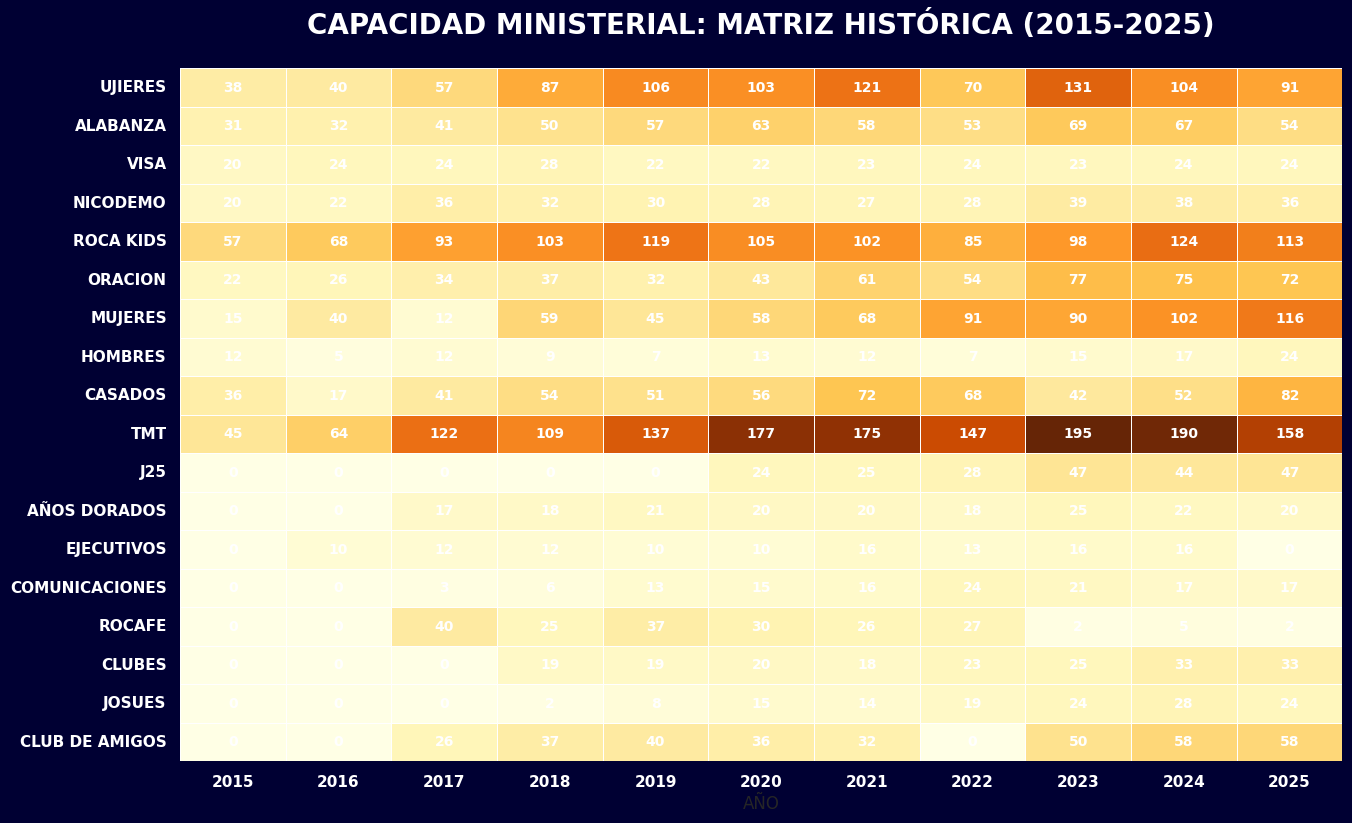


--------------------------------------------------

🖼️  Visualizando Diapositivas Finales (PNG Assets)...


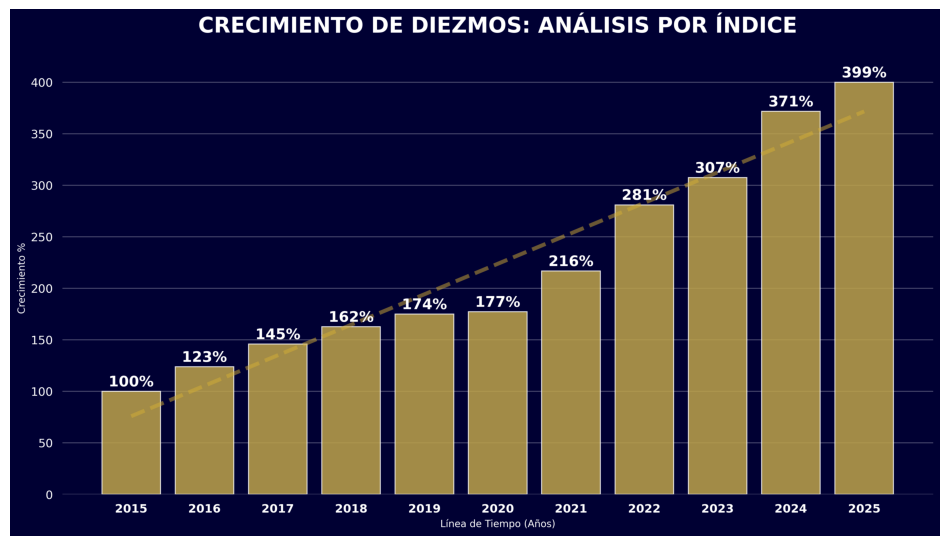

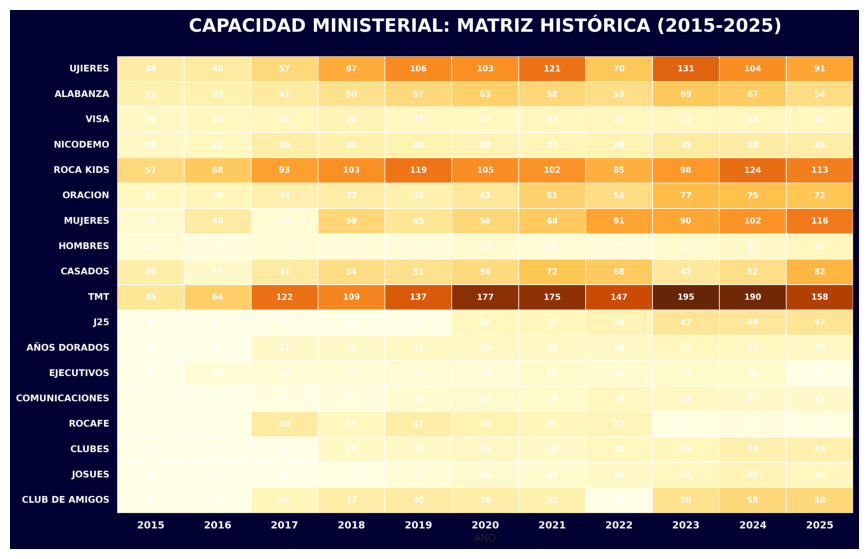

════════════════════════════════════════════════════════════
✅ VISUALIZACIÓN HARDCORE COMPLETADA - SISTEMA READY
════════════════════════════════════════════════════════════


In [60]:
# -----------------------------------------------------------------------------
# Autor: Pedro J. Lancheros / Peter Boat
# Fecha: 2026-01-30
# Hora: 16:45 (-5 UTC)
# Versión: v26.2 (Visualización Hardcore)
# Bloque: #4 - Visualización y Renderizado en Colab
# -----------------------------------------------------------------------------

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# --- 1. CONFIGURACIÓN VISUAL (ESTÁNDAR PJLA) ---
plt.rcParams['font.family'] = 'DejaVu Sans'
NAVY_BG = "#000033"

def renderizar_visuales_pjla():
    print(f"📡 Iniciando Renderizado de Activos...")
    print("-" * 50)

    # A. Renderizado del Heatmap (Data en Memoria)
    if 'df_siervos' in locals() or 'df_siervos' in globals():
        print("📊 Generando Matriz de Calor de Ministerios...")
        # Preparamos la matriz: Ministerios en Y, Años en X
        df_viz = df_siervos.set_index('AÑO').drop(columns=['TOTAL_PERSONAS'], errors='ignore').T

        plt.figure(figsize=(15, 9), facecolor=NAVY_BG)
        sns.heatmap(df_viz, annot=True, fmt=".0f", cmap="YlOrBr", cbar=False,
                    linewidths=.5, annot_kws={"size": 10, "weight": "bold", "color": "white"})

        plt.title("CAPACIDAD MINISTERIAL: MATRIZ HISTÓRICA (2015-2025)",
                  color="white", fontsize=20, pad=25, fontweight='bold')
        plt.xticks(color="white", fontweight='bold')
        plt.yticks(color="white", fontweight='bold')
        plt.show()
    else:
        print("❌ ERROR: La variable 'df_siervos' no se encuentra en el Staging Area.")

    print("\n" + "-"*50 + "\n")

    # B. Renderizado de Slides (Archivos PNG Inyectados)
    print("🖼️  Visualizando Diapositivas Finales (PNG Assets)...")
    assets = [
        os.path.join(OUTPUT_FOLDER, "diezmos_crecimiento.png"),
        os.path.join(OUTPUT_FOLDER, "heatmap_siervos.png")
    ]

    for slide_path in assets:
        if os.path.exists(slide_path):
            plt.figure(figsize=(12, 7))
            img = mpimg.imread(slide_path)
            plt.imshow(img)
            plt.axis('off') # Estética de diapositiva
            plt.show()
        else:
            print(f"⚠️  Activo no encontrado en producción: {os.path.basename(slide_path)}")

    print("═"*60)
    print("✅ VISUALIZACIÓN HARDCORE COMPLETADA - SISTEMA READY")
    print("═"*60)

# --- EJECUCIÓN ---
renderizar_visuales_pjla()